# Titanic

## 1. Preprocessing Pipeline

In [ ]:
from sklearn import set_config

set_config(transform_output="pandas")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
# reading
url = "https://drive.google.com/file/d/1g3uhw_y3tboRm2eYDPfUzXXsw8IOYDCy/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = df = pd.read_csv(path)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
# X and y creation
X = data.drop(columns=["PassengerId", "Name", "Ticket"])
y = X.pop("Survived")

In [ ]:
# Feature Engineering
X.loc[:, "Cabin"] = X.Cabin.str[0]

In [ ]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
X_cat_col = X.select_dtypes(exclude="number").copy().columns
X_num_col = X.select_dtypes(include="number").copy().columns

In [ ]:
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

In [ ]:
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(handle_unknown="ignore",sparse_output=False)
)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_col),
        ("cat_pipe", categoric_pipe, X_cat_col),
    ]
)

## 2. Modelling (Decision Tree)

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor,
                              DecisionTreeClassifier())

In [ ]:
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}

In [ ]:
search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1,
                      scoring='accuracy'
                      )

In [ ]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='N_A',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncod...
                                                                                                        sparse_output=False))]),
                                                                         Index(['Sex', 'Cabin', 'Embarked'], dtype='object'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'decisiontreeclassifier__max_depth': range(2, 14, 2),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 12, 2)},
             scoring='roc_auc', verbose=1)

In [ ]:
tree_score = accuracy_score(y_test,search.predict(X_test))

In [ ]:
search.best_score_

0.7944418326771266

In [ ]:
scores = pd.DataFrame({"model" : ['dtree'],"score":[tree_score]})

scores

,model,score
0,dtree,0.843575
1,dtree_precision,0.826816


## 3. Error analysis

In [ ]:
# test accuracy
accuracy_score(search.predict(X_test), y_test)

0.8435754189944135

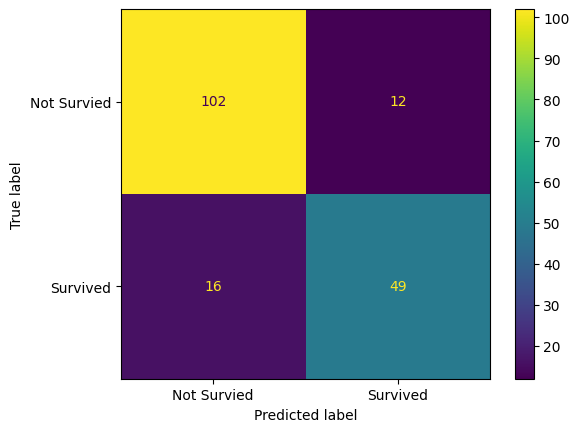

In [ ]:
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(search, X_test, y_test, display_labels=['Not Survied', 'Survived']);

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(search,
                                      X_test,
                                      y_test,
                                      display_labels=['Not Survied', 'Survived']);

# 4. Build the same pipeline using a KNN instead of a decision tree.

In [ ]:
# solution
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

knn_full_pipeline = make_pipeline(preprocessor,
                                  StandardScaler(),
                                  KNeighborsClassifier()
                                 )
from sklearn.model_selection import GridSearchCV

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "kneighborsclassifier__n_neighbors": range(2, 50),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}

knn_search = GridSearchCV(knn_full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

knn_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='N_A',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncod...
                                                                                                        sparse_output=False))]),
                                                                         Index(['Sex', 'Cabin', 'Embarked'], dtype='object'))])),
                                       ('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'kneighborsclassifier__n_neighbors': range(2, 50),
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             verbose=1)

In [ ]:
knn_score = accuracy_score(y_test,knn_search.predict(X_test))

In [ ]:
pd.concat([scores,pd.DataFrame({"model" : ['knn'],"score":[knn_score]})],axis=0)

,model,score
0,dtree,0.843575
1,dtree_precision,0.826816
0,knn,0.826816


In [ ]:
knn_search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'median',
 'kneighborsclassifier__n_neighbors': 32,
 'kneighborsclassifier__weights': 'distance'}